In [1]:
from IPython.display import display, Image
from sklearn.utils import shuffle

from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, Dense
from keras.layers import Input, concatenate
from keras.models import Sequential, Model, load_model, model_from_json
from keras.utils import plot_model
from keras import backend as K

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import itertools
import pickle
import keras
import time
import os

Using TensorFlow backend.


In [2]:
BALANCED = False
model_dir = os.path.join(os.getcwd(), "models")

## Utilities

In [3]:
def plot_confusion_matrix(cm, class_labels, model_name, cmap=plt.cm.Blues):
    diagram_dir = os.path.join(os.getcwd(), "images")
    if not os.path.exists(diagram_dir):
        os.makedirs(diagram_dir)
    
    stats_dir = os.path.join(os.getcwd(), "stats")
    if not os.path.exists(stats_dir):
        os.makedirs(stats_dir)
    
    # create the figure
    fig = plt.figure()
    fig.set_size_inches(18,15)
    
    # labels
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
    # tick marks
    class_count = len(class_labels)
    tick_marks = np.arange(class_count + 1)
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    # normalization
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, 6)
    
    # numbers
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")
    
    # color bar
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    # save and show
    np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})
    plt.savefig(os.path.join(diagram_dir, model_name + "_confusion_matrix.png"), dpi=100)
    pd.DataFrame(cm).to_csv(os.path.join(stats_dir, model_name + "_confusion_matrix.txt"), header=None, index=None)
    plt.show(block=False)
    

def graph_history(loss_history, n_iterations, interval):
    # create the figure
    fig, ax1 = plt.subplots()
#     ax2 = ax1.twinx()
    
    # plot the stuff
    iterations = interval * (np.arange(n_iterations // interval) + 1)
    ax1.plot(iterations, loss_history, label="Loss", color="c")
#     ax2.plot(iterations, acc_history, label="Val. Accuracy", color="m")
    
    # also, indicate the iteration with the best loss
    ax1.axvline(interval * (np.argmin(loss_history) + 1), color="k", linestyle="--")

    # pretty-fy the plot
    ax1.set_xlabel("Training Iteration")
    ax1.set_ylabel("Loss")
#     ax2.set_ylabel("Accuracy")
    fig.legend()

    # plt.savefig(os.path.join(os.getcwd(), "images", "history.png"), dpi=100)
    plt.show()

    
def save_model(model, model_name):
    directory = os.path.join(model_dir)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # save architecture
    with open(os.path.join(directory, model_name + ".json"), "w+") as f:
        f.write(model.to_json())
    
    # save weights
    model.save_weights(os.path.join(directory, model_name + "_weights.h5"))

def load_model(model_name):
    directory = os.path.join(model_dir)

    if os.path.exists(directory):
        # load the architecture
        json_file = open(os.path.join(directory, model_name + ".json"))
        model = model_from_json(json_file.read())
        model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
        json_file.close()

        # load the weights and return the model
        model.load_weights(os.path.join(directory, model_name + "_weights.h5"))
        return model

## Load data

In [4]:
# root path
filename = "data/snapshots/unfiltered_snapshots.csv"

# load the csv
print("Loading snapshots...", end=" ")
col_names = pd.read_csv(filename, nrows=0).columns
types_dict = {"Vehicle": int, "Capture": int}
types_dict.update({col: int for col in col_names if col not in types_dict})
df = pd.read_csv(filename, dtype=types_dict)  
print("done!")

display(df.sample(frac=0.0001).head(5))

Loading snapshots... done!


,Vehicle,Capture,Data 1,Data 2,Data 3,Data 4,Data 5,Data 6,Data 7,Data 8,...,Data 1015,Data 1016,Data 1017,Data 1018,Data 1019,Data 1020,Data 1021,Data 1022,Data 1023,Data 1024
42773,3,7,0,0,0,0,0,0,0,0,...,0,0,0,128,255,0,0,0,2,194
215586,6,22,80,16,11,240,96,0,0,0,...,0,0,0,0,80,17,4,148,86,32
24493,3,5,83,233,0,0,0,0,1,215,...,0,0,128,0,0,0,0,128,133,255
269606,8,52,2,190,0,0,128,0,0,255,...,38,64,39,109,132,39,0,25,0,233
86581,3,12,207,0,12,0,0,2,1,255,...,0,90,2,26,0,0,63,255,255,255


In [5]:
# filter down to Stone's vehicles
df = df[df["Vehicle"] > 100]

## Split into known/unknown sets

In [6]:
# randomly select known vehicles
all_vehicles = df["Vehicle"].unique()
known_vehicles = np.random.choice(all_vehicles, size=int(all_vehicles.shape[0] * 0.75), replace=False)

# balance the dataset
if BALANCED:
    min_size = np.min(df["Vehicle"].value_counts())
    balanced_df = df.groupby("Vehicle", group_keys=False).apply(pd.DataFrame.sample, n=min_size)

# pick the desired dataframe
samples = df if not BALANCED else balanced_df

# split the dataframe into known/unknown
known_df = samples[samples["Vehicle"].isin(known_vehicles)]
unknown_df = samples[~samples["Vehicle"].isin(known_vehicles)]

# save these
known_vehicles = known_df["Vehicle"].unique()
unknown_vehicles = unknown_df["Vehicle"].unique()

print("Known vehicles   :", known_vehicles)
print("Unknown vehicles :", unknown_vehicles)

Known vehicles   : [102 104 105 106 107 109 110 111]
Unknown vehicles : [101 103 108]


In [7]:
# split into (x, y) sets
known_x = known_df.drop(columns=["Vehicle", "Capture"])
known_y = known_df["Vehicle"]

unknown_x = unknown_df.drop(columns=["Vehicle", "Capture"])
unknown_y = unknown_df["Vehicle"]

# scale the inputs
known_x /= 255
unknown_x /= 255

# add the extra dimensions
known_x = np.expand_dims(known_x, axis=2)
unknown_x = np.expand_dims(unknown_x, axis=2)

In [8]:
# restructure the known vehicles
print("Training set")
train_x = []

for vehicle in known_vehicles:
    samples = []
    indices = np.where(known_y == vehicle)[0]
    
    for idx in indices:
        samples.append(known_x[idx])
    
    train_x.append(np.stack(samples))
    print(train_x[-1].shape)

# restructure the unknown vehicles
print("\nTesting set")
test_x = []

for vehicle in unknown_vehicles:
    samples = []
    indices = np.where(unknown_y == vehicle)[0]
    
    for idx in indices:
        samples.append(unknown_x[idx])
    
    test_x.append(np.stack(samples))
    print(test_x[-1].shape)

Training set
(1856, 1024, 1)
(2221, 1024, 1)
(3806, 1024, 1)
(1709, 1024, 1)
(2220, 1024, 1)
(2564, 1024, 1)
(2980, 1024, 1)
(2101, 1024, 1)

Testing set
(4115, 1024, 1)
(1812, 1024, 1)
(3041, 1024, 1)


## Build a one-shot batch

In [9]:
# build a set of [n] sample triplets
def make_batch(n, samples):
    # save these numbers
    n_vehicles = len(samples)
    length = 1024
    width = 1
    
    # initialize three empty arrays (anchor, positive, negative) for the input batch
    x = [np.zeros((n, length, width)) for i in range(3)]
    
    # randomly select [n] vehicles
    vehicles = np.random.choice(n_vehicles, size=(n,))
    
    # for each triplet...
    for i in range(n):
        # select the vehicles
        anchor_vehicle = vehicles[i]
        positive_vehicle = anchor_vehicle
        negative_vehicle = (anchor_vehicle + np.random.randint(1, n_vehicles)) % n_vehicles
        
        # select the samples
        anchor_sample = np.random.randint(0, len(samples[anchor_vehicle]))
        positive_sample = np.random.randint(0, len(samples[positive_vehicle]))
        negative_sample = np.random.randint(0, len(samples[negative_vehicle]))

        # copy the samples into the batch
        x[0][i, :, :] = samples[anchor_vehicle][anchor_sample]
        x[1][i, :, :] = samples[positive_vehicle][positive_sample]
        x[2][i, :, :] = samples[negative_vehicle][negative_sample]
        
    return x

## Triplet loss

In [10]:
# compute loss for an anchor, a positive sample, and a negative sample
def triplet_loss(y_true, y_pred, alpha=0.4):
    size = y_pred.shape.as_list()[-1]
    y_pred = tf.reshape(y_pred, (size, -1))
    
    # split the embeddings
    anchor = y_pred[:int(size * 1/3)]
    positive = y_pred[int(size * 1/3):int(size * 2/3)]
    negative = y_pred[int(size * 2/3):]
    
    # compute the distances
    positive_distance = K.sum(K.square(anchor - positive), axis=1)
    negative_distance = K.sum(K.square(anchor - negative), axis=1)

    # compute total loss
    loss = positive_distance - negative_distance + alpha
    return K.maximum(loss, 0)

## Build embedding neural network

In [11]:
def initialize_weights(size):
    return np.random.normal(loc=0.0, scale=1e-2, size=size)

def initialize_bias(size):
    return np.random.normal(loc=0.5, scale=1e-2, size=size)

def build_base_model(filters, input_shape):
    model = Sequential()
    model.add(Conv1D(filters[0], 4, input_shape=input_shape, padding="same",
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D())
    
    model = Sequential()
    model.add(Conv1D(filters[1], 4, input_shape=input_shape, padding="same",
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D())
    
    # user-configurable stuff
    for i in filters[2:]:
        model.add(Conv1D(i, 4, padding="same", kernel_initializer=initialize_weights,
            bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
        model.add(Conv1D(i, 4, padding="same", kernel_initializer=initialize_weights,
            bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
        model.add(Conv1D(i, 4, padding="same", kernel_initializer=initialize_weights,
            bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling1D())
        
    model.add(Flatten())
    model.add(Dense(128, activation="sigmoid", kernel_initializer=initialize_weights,
                    bias_initializer=initialize_bias, kernel_regularizer=l2(1e-3)))
    
    plot_model(model, to_file="base_model.png", show_shapes=True, show_layer_names=True)
    return model

In [12]:
def build_siamese_model(filters, input_shape):
    # construct base network
    siamese = build_base_model(filters=filters, input_shape=(1024,1))

    # get the inputs
    anchor_input = Input(shape=(1024,1))
    positive_input = Input(shape=(1024,1))
    negative_input = Input(shape=(1024,1))

    # encode the inputs
    encoded_anchor = siamese(anchor_input)
    encoded_positive = siamese(positive_input)
    encoded_negative = siamese(negative_input)

    # join the encodings
    merged = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1)

    # build and compile the model
    model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged)
    model.compile(loss=triplet_loss, optimizer=Adam(lr=0.01))

    # plot and return the model
    plot_model(model, to_file="siamese_model.png", show_shapes=True, show_layer_names=True)
    return model

## Train and test one-shot learning

[32, 32, 64, 32, 128, 64]
Instructions for updating:
Colocations handled automatically by placer.


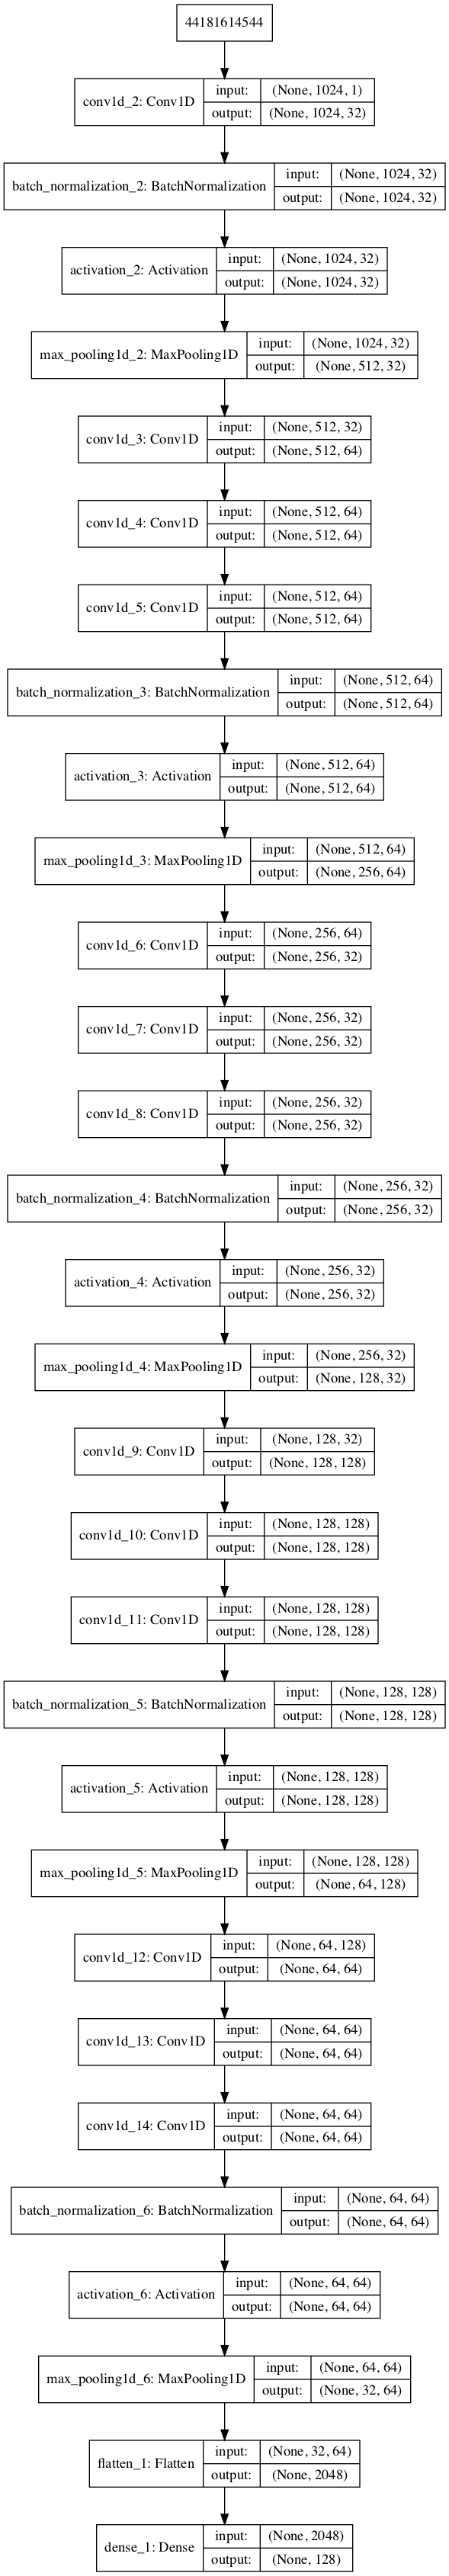

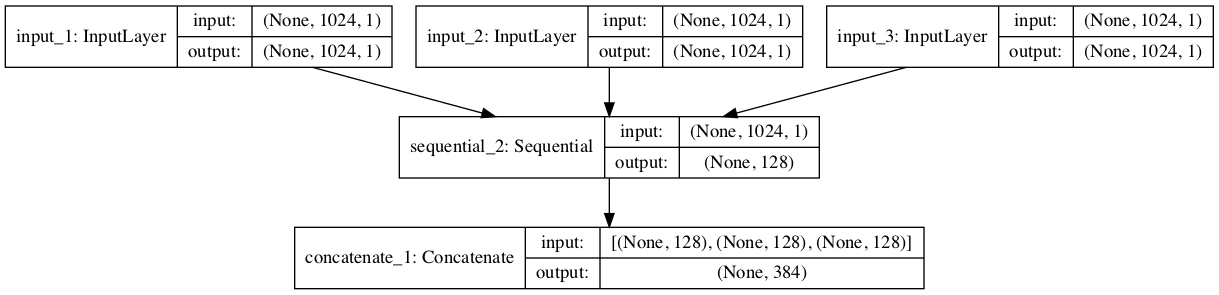

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1024, 1)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1024, 1)      0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          534912      input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [ ]:
# hyperparameters
interval = 500  # interval for evaluating on one-shot tasks
batch_size = 1  # number of image triplets in the training batch
n_iterations = 30000  # number of training iterations
n_vehicles = len(unknown_vehicles)  # number of classes for each one-shot test

# model configurations
filter_sets = [
    [32, 32, 64, 32, 128, 64],
]

# for each configuration...
for filters in filter_sets:
    # build the model
    print(filters)
    model = build_siamese_model(filters=filters, input_shape=(1024,1))
    
    # show it
    display(Image(filename="base_model.png", width=400))
    display(Image(filename="siamese_model.png", width=800))
    model.summary()
    
    # train the model
    # how long does this take?
    start_time = time.time()

    print("Training model")
    print("-" * 50)

    # we'll need this
    loss_history = []

    # for each training iteration...
    for i in range(1, n_iterations + 1):
        # make a training batch and train the model using this batch
        inputs = make_batch(batch_size, train_x)
        loss = model.train_on_batch(inputs, np.zeros((batch_size, 0, 384, 1)))

        # if it's time to evaluate the model...
        if i % interval == 0:
            # output some stats
            print("\n{}\n".format("-" * 20))
            print("Time for {} iterations: {:.2f} mins".format(i, (time.time() - start_time) / 60.))
            print("Train loss: {:.6f}".format(loss))
            loss_history.append(loss)

            # save model
            # model.save_weights(os.path.join(model_dir, "weights.{}.h5".format(i)))

    print("Elapsed time: {:.2f} minutes".format((time.time() - start_time) / 60.))

    # show the training loss and accuracy over time
    graph_history(loss_history, n_iterations, interval)

    # stats for best iteration
    best_iteration = interval * (np.argmin(loss_history) + 1)
    print("Best iteration :", best_iteration)
    print("Training loss  :", np.min(loss_history))

In [ ]:
# here